# Template for reinforcement learning applied to the CartPole benchmark

# Settings

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import gym
import numpy as np
import bisect
import math
import os
import random
import tensorflow as tf

from agents.random_agent import run_episode_random_agent
from agents.human_crafted_agent import human_decision, run_episode_human_crafted_agent

tf.logging.set_verbosity(tf.logging.WARN)  # Remove Info logs

/home/remy/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gym.make("CartPole-v1")

In [3]:
print(env.action_space)  # 0 or 1

obs = env.reset()
print(obs)  # position, velocity, angle, angular_velocity
print(env._max_episode_steps)

observation_space_dimension = env.observation_space.shape[0]
print(observation_space_dimension)

Discrete(2)
[ 0.03718286 -0.04773799 -0.04078356 -0.03653672]
500
4


# Observing the values

In [4]:
nb_episodes = 1000
positions = []
velocities = []
angles = []
angular_velocities = []

for episode in range(0, nb_episodes):
    obs = env.reset()
    done = False
    final_score = 0

    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        position, velocity, angle, angular_velocity = obs
        positions.append(position)
        velocities.append(velocity)
        angles.append(angle)
        angular_velocities.append(angular_velocity)        

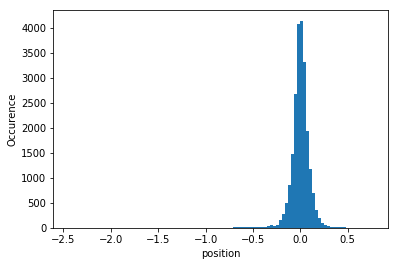

In [5]:
plt.hist(positions, bins=100)
plt.xlabel('position');
plt.ylabel('Occurence');

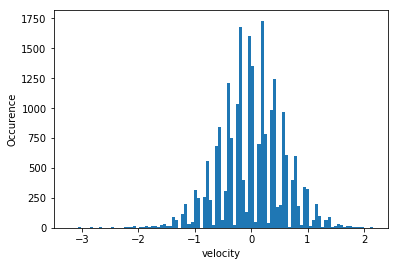

In [6]:
plt.hist(velocities, bins=100)
plt.xlabel('velocity');
plt.ylabel('Occurence');

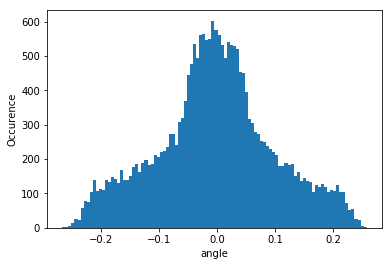

In [7]:
plt.hist(angles, bins=100)
plt.xlabel('angle');
plt.ylabel('Occurence');

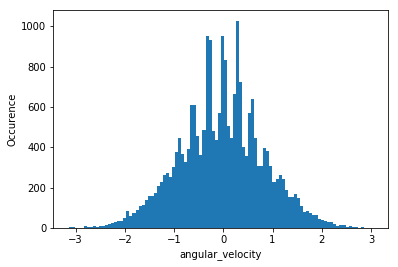

In [8]:
plt.hist(angular_velocities, bins=100)
plt.xlabel('angular_velocity');
plt.ylabel('Occurence');

# Policy gradient

## Computational graph

In [9]:
tf.reset_default_graph()

nb_neurons_input = 4  # len(obs)
nb_neurons_hidden_layer = 4
nb_neurons_output = 1

X = tf.placeholder(shape=[None, nb_neurons_input], dtype=tf.float32, name="X")

with tf.name_scope("dnn"): 
    initializer_w = tf.contrib.layers.xavier_initializer()
    initializer_b = tf.zeros_initializer() 
    hidden = tf.layers.dense(X, nb_neurons_hidden_layer, \
                             activation=tf.nn.elu, \
                             kernel_initializer=tf.contrib.layers.xavier_initializer(), \
                             name="hidden")
    output = tf.layers.dense(hidden, nb_neurons_output, 
                             activation=tf.nn.sigmoid,
                             name="output")  # proba of moving kart to left

init = tf.global_variables_initializer()

## Playing an episode - before training

In [10]:
def run_episode_neural_network(show_renderer=False):    
    with tf.Session() as sess:
        init.run()
        obs = env.reset()
        obs_pretty = obs.reshape(1, nb_neurons_input)
        done = False
        final_score = 0
        while not done:
            if show_renderer:
                env.render()
            proba_move_to_left = output.eval(feed_dict={X: obs_pretty})        
            if random.uniform(0, 1) < proba_move_to_left:
                action = 0  # move to left
            else:
                action = 1       
            obs, reward, done, info = env.step(action) 
            if done:
                break
            final_score += reward
    env.reset()
    env.close()
    return final_score

In [11]:
scores = []
nb_episodes = 100

for i in range(0, nb_episodes):
    episode_score = run_episode_neural_network()
    scores.append(episode_score)

23.33


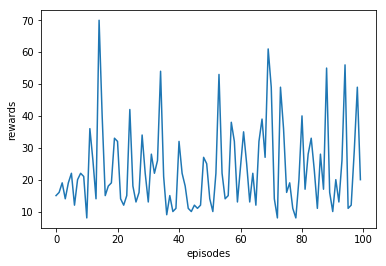

In [12]:
print(np.mean(scores))
plt.plot(scores)
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()

# A2C policy gradient